# Zonal statistics of solar time series in GRASS GIS with Python

[<img src="https://grass.osgeo.org/uploads/images/logo/grassgis_logo_colorlogo_text_alphabg.png" alt="GRASS GIS" style="width:200px;"/>](https://grass.osgeo.org/)

This is a quick introduction into *GRASS GIS* in a *Jupyter Notebook* using the *Python* scripting language.
The interactive notebook is available online thanks to the [*Binder*](https://mybinder.org/) service.

Examples here are using a sample GRASS GIS dataset for North Carolina, USA. The dataset is included in this environment.

## Usage

To run the selected part which is called a cell, hit `Shift + Enter`.

## Start

There is several ways how GRASS GIS can be used. When using Python in notebook, we usually find GRASS GIS Python packages, import them, initialize GRASS GIS session, and set several variables useful for using GRASS GIS in a notebook.

In [1]:
# import Python standard library and IPython packages we need
import os
import sys
import subprocess
import csv
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# show matplotlib outputs automatically in the notebook
%matplotlib inline

# ask GRASS GIS where its Python packages are
gisbase = subprocess.check_output(["grass", "--config", "path"]).strip()
os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# import GRASS GIS packages we need
import grass.script as gs
import grass.script.setup as gsetup

# create GRASS GIS session
rcfile = gsetup.init(gisbase, "data/grassdata", "nc_basic_spm_grass7", "user1")

# we want functions to raise exceptions and see standard output of the modules
gs.set_raise_on_error(True)
gs.set_capture_stderr(True)
# simply overwrite existing maps like we overwrite Python variable values
os.environ['GRASS_OVERWRITE'] = '1'
# enable map rendering to in Jupyter Notebook
os.environ['GRASS_FONT'] = 'sans'
# set display modules to render into a file (named map.png by default)
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

## Watersheds

Set computational region and create...

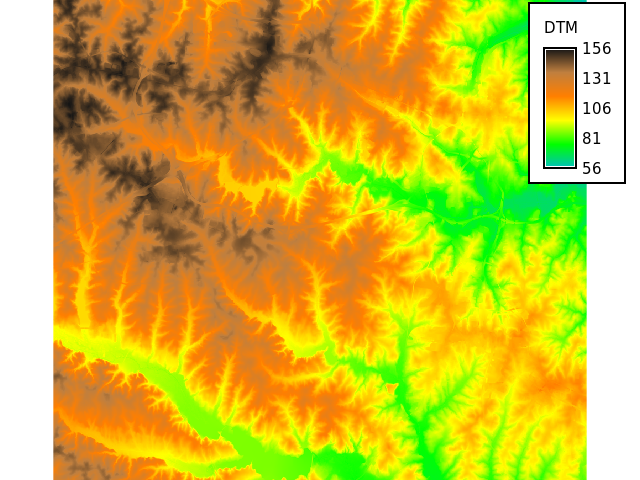

In [2]:
# Set computational region to the study area.
gs.parse_command('g.region', raster="elevation", flags='pg')
# Draw elevation (DTM) to get an overview of the area.
gs.run_command('d.erase')
gs.run_command('d.rast', map="elevation")
gs.run_command('d.legend', raster="elevation", at=(65, 90, 85, 90), fontsize=15, flags="b", title="DTM")
Image(filename="map.png")

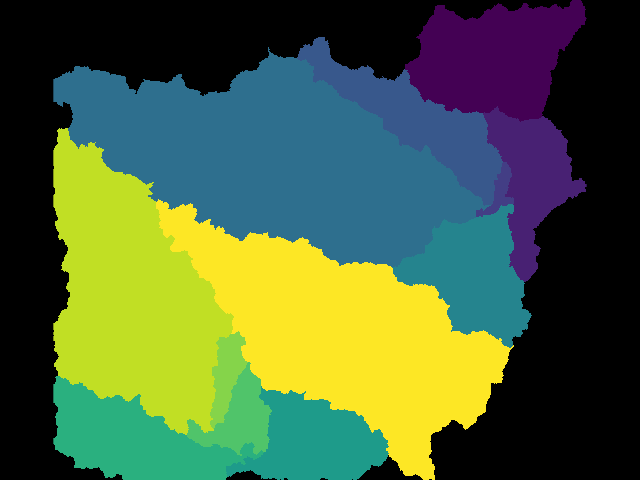

In [3]:
# Determine watersheds.
gs.run_command("r.watershed", elevation="elevation", basin="watersheds", threshold=80000)
# View them.
gs.run_command("r.colors", map="watersheds", color="viridis")
gs.run_command('d.erase', background="black")
gs.run_command('d.rast', map="watersheds")
Image(filename="map.png")

## Compute zonal statistics

Each watershed is a zone.

In [4]:
# Get the univariate zonal statistics of elevations as CSV.
separator = "|"
text = gs.read_command("r.univar", map="elevation", zones="watersheds", separator=separator, flags="t")
reader = csv.DictReader(text.splitlines(), delimiter=separator)

In [5]:
# Restructure the table of statistics as dictionary by watershed category (zone).
univars_for_watersheds = {}
for row in reader:
    category = row["zone"]
    univars_for_watersheds[category] = row

# Get watershed categories as a list of strings. 
# We are asking r.describe not to give us nulls if present
# because they denote incomplete watersheds.
categories = gs.read_command("r.describe", flags="1n", map="watersheds").splitlines()
    
# Get mean and standard deviation of elevations as lists.
means_for_streams = []
stddev_for_streams = []
for category in categories:
    means_for_streams.append(float(univars_for_watersheds[category]["mean"]))
    stddev_for_streams.append(float(univars_for_watersheds[category]["stddev"]))

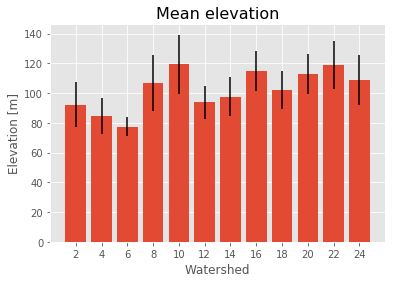

In [6]:
bar_positions = np.arange(len(categories))
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.set_title("Mean elevation", fontsize=16)
ax.set_xlabel("Watershed")
ax.set_ylabel("Elevation [m]")
ax.bar(bar_positions, means_for_streams, yerr=stddev_for_streams)
ax.set_xticks(bar_positions)
ax.set_xticklabels(categories)
plt.show()